In [1]:
import numpy as np
import pandas as pd
import pickle
import os
import sys
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale
from joblib import Parallel, delayed
import random
from meta_dataset_creation.utils import get_score, get_unsupervised_score

algorithm = "haverage"
eval_metric = "sil"
dataset_dir = "datasets/mixed/original/"
benchmark_results_dir = f"meta_dataset_creation/data/benchmark_results/{algorithm}/original/scores/"

In [2]:
dataset_id = "49"
with open(os.path.join(dataset_dir, f"{dataset_id}.pickle"), "rb") as f:
    dataset = pickle.load(f)
with open(os.path.join(benchmark_results_dir, f"{dataset_id}.pickle"), "rb") as f:
    benchmark_results = pickle.load(f)

In [3]:
scores = {sim_pair: max([v["score"] for v in benchmark_results[sim_pair][eval_metric]]) for sim_pair in benchmark_results}
scores["sqeuclidean_hamming"], max(scores.values())

(0.5632503771874637, 0.6110086422407229)

In [78]:
from sklearn.cluster import spectral_clustering, AgglomerativeClustering
from sklearn.metrics import normalized_mutual_info_score
from sklearn.linear_model import LogisticRegression
from kmedoids import fasterpam

metrics = ["euclidean", "manhattan", "cosine"]
weights = ["uniform", "distance"]

    # params = []
    # for i in range(Xnum.shape[1]):
    #     params.append(np.zeros(11))
    # for i in range(Xnum.shape[1]):
    #     params.append(np.zeros(11))
    # return params

def get_num_sim(solution, xnum1, xnum2):
    sim = 0
    sum_weights = 0
    attribute = 0
    for i in range(len(xnum1)):
        w = solution[attribute][-1]
        if w > 0:
            bin_size = 1 / (len(solution[attribute])-1)
            diff = abs(xnum1[i] - xnum2[i])
            # index = 1 + diff * (len(solution[attribute])-1)
            ind_a = int(diff/bin_size)
            a, sim_a = ind_a * bin_size, solution[attribute][ind_a]
            if diff % bin_size == 0:
                sim += w*sim_a
            else:
                ind_b = ind_a + 1
                b, sim_b = ind_b * bin_size, solution[attribute][ind_b]
                sim += w*(sim_b - sim_a)/(b - a)*(diff - a)
            sum_weights += w
        attribute += 1
    return sim / sum_weights

def get_cat_sim(solution, xcat1, xcat2):
    sim = 0
    sum_weights = 0
    attribute = 0
    for i in range(len(xcat1)):
        w = solution[attribute][-1]
        if w > 0:
            n_categories = (1 + np.sqrt(1 + 8*(len(solution[attribute])-1)))/2 # n**2 - n - 2*(len(solution[attribute])-1) = 0 => n = (-b + sqrt(Delta)/2a)
            m = np.identity(n_categories)
            iu = np.triu_indices(n_categories, 1)
            m[iu] = solution[attribute][:-1]
            sim += w*m[min(xcat1[i], xcat2[i]), max(xcat1[i], xcat2[i])]
            sum_weights += w
        attribute += 1
    return sim / sum_weights

def get_sim(solution, xnum1, xcat1, xnum2, xcat2):
    sim = 0
    sum_weights = 0
    attribute = 0
    for i in range(len(xnum1)):
        w = solution[attribute][-1]
        if w > 0:
            bin_size = 1 / (len(solution[attribute])-2)
            diff = abs(xnum1[i] - xnum2[i])
            # index = 1 + diff * (len(solution[attribute])-1)
            ind_a = int(diff/bin_size)
            a, sim_a = ind_a * bin_size, solution[attribute][ind_a]
            if diff % bin_size == 0:
                sim += w*sim_a
            else:
                ind_b = ind_a + 1
                b, sim_b = ind_b * bin_size, solution[attribute][ind_b]
                sim += w*(sim_b - sim_a)/(b - a)*(diff - a)
            sum_weights += w
        attribute += 1
    for i in range(len(xcat1)):
        w = solution[attribute][-1]
        if w > 0:
            n_categories = int((1 + np.sqrt(1 + 8*(len(solution[attribute])-1)))/2) # n**2 - n - 2*(len(solution[attribute])-1) = 0 => n = (-b + sqrt(Delta)/2a)
            m = np.identity(n_categories)
            iu = np.triu_indices(n_categories, 1)
            m[iu] = solution[attribute][:-1]
            # print(min(xcat1[i], xcat2[i]), max(xcat1[i], xcat2[i]))
            sim += w*m[min(xcat1[i], xcat2[i]), max(xcat1[i], xcat2[i])]
            sum_weights += w
        attribute += 1
    return sim / sum_weights

def get_num_sim_matrix(solution, Xnum):
    sim_matrix = np.identity(Xnum.shape[0])
    for i in range(Xnum.shape[0] - 1):
        for j in range(i + 1, Xnum.shape[0]):
            sim_matrix[i, j] = get_num_sim(solution, Xnum[i], Xnum[j])
            sim_matrix[j, i] = sim_matrix[i, j]
    return sim_matrix

def get_cat_sim_matrix(solution, Xcat):
    sim_matrix = np.identity(Xnum.shape[0])
    for i in range(Xnum.shape[0] - 1):
        for j in range(i + 1, Xnum.shape[0]):
            sim_matrix[i, j] = get_cat_sim(solution, Xcat[i], Xcat[j])
            sim_matrix[j, i] = sim_matrix[i, j]
    return sim_matrix

def get_sim_matrix(solution, Xnum, Xcat):
    sim_matrix = np.identity(Xnum.shape[0])
    for i in range(Xnum.shape[0] - 1):
        # print(i, Xnum.shape[0])
        for j in range(i + 1, Xnum.shape[0]):
            sim_matrix[i, j] = get_sim(solution, Xnum[i], Xcat[i], Xnum[j], Xcat[j])
            sim_matrix[j, i] = sim_matrix[i, j]
    return sim_matrix

def fitness(solution, Xnum, Xcat, n_clusters, return_cluster=False) -> float:
    sim_matrix = get_sim_matrix(solution, Xnum, Xcat)
    clusters = AgglomerativeClustering(n_clusters, metric="precomputed", linkage="average").fit_predict(1 - sim_matrix)
    # clusters = fasterpam(1 - sim_matrix, n_clusters, n_cpu=-1).labels

    # cluster_elems = {}
    # for i, c in enumerate(clusters):
    #     if c not in cluster_elems:
    #         cluster_elems[c] = []
    #     cluster_elems[c].append(i)
    # fitness = 0
    # for i, c in enumerate(clusters):
    #     if len(cluster_elems[c]) > 1:
    #         s1 = max(sim_matrix[i][[j for j in cluster_elems[c] if j!=i]])
    #         s2 = max(sim_matrix[i][[j for j in range(len(clusters)) if j not in cluster_elems[c]]])
    #     fitness += (s1 - s2)/max(s1, s2)
    # fitness /= len(clusters)
    fitness = get_unsupervised_score(1 - sim_matrix, clusters, eval_metric=eval_metric, metric="precomputed")
    penalization = max([normalized_mutual_info_score(clusters, Xcat[:, j]) for j in range(Xcat.shape[1])])
    lr_score = 0
    for j in range(Xnum.shape[1]):
        s = LogisticRegression().fit(Xnum[:,[j]], clusters).score(Xnum[:,[j]], clusters)
        if not np.isnan(s): lr_score=max(lr_score, s)
    penalization += 0.1*lr_score
    fitness = fitness - min(fitness, penalization)
    if return_cluster:
        return fitness, clusters
    return fitness

def select(pop, fitnesses):
    idx = np.random.choice(np.arange(POP_SIZE), size=POP_SIZE, replace=True, p=fitnesses/fitnesses.sum())
    return [pop[i] for i in idx]

def crossover(parent1, pop):
    if np.random.rand() < CROSS_RATE:
        i = np.random.randint(0, POP_SIZE, size=1)[0]
        parent2 = pop[i]
        l = np.random.choice(len(parent1), size=np.random.randint(len(parent1)))
        child = [parent1[j] if j in l else parent2[j] for j in range(len(parent1))]
        return child
    return parent1

def gen_mutate(current_value, min_=0, max_=1):
    if np.random.rand() < MUTATION_RATE:
        new_value = current_value + (2*np.random.rand()-1)*MUTATION_FACTOR
        new_value = max(min_, new_value)
        new_value = min(max_, new_value)
        return new_value
    return current_value
    
def mutate(child, n_num_attributes):
    for i in range(n_num_attributes):
        for j in range(1, len(child[i])-1):
            child[i][j] = gen_mutate(child[i][j], max_=child[i][j-1])
        child[i][-1] = gen_mutate(child[i][-1])
    for i in range(n_num_attributes, len(child)):
        for j in range(len(child[i])-1):
            child[i][j] = gen_mutate(child[i][j])
        child[i][-1] = gen_mutate(child[i][-1])
    return child

In [79]:
# %%time
from tqdm import tqdm
from copy import deepcopy

# hyperparameters for genetic algorithm
POP_SIZE = 100
CROSS_RATE = 0.8
MUTATION_RATE = 0.2
MUTATION_FACTOR = 0.1
N_GENERATIONS = 100
FITNESS_EARLY_STOP_THRESH = 1

Xnum = minmax_scale(dataset["Xnum"])
Xcat = dataset["Xcat"].copy()
for j in range(Xcat.shape[1]):
    _, Xcat[:, j] = np.unique(Xcat[:, j], return_inverse=True)
n_clusters = len(set(dataset["y"]))

# build a population
pop = []
for i in range(POP_SIZE):
    entity = []
    for i in range(Xnum.shape[1]):
        l = [1]
        for _ in range(100):
            l.append(min(l[-1], np.random.rand()))
        l.append(np.random.rand())
        entity.append(np.array(l))
    for i in range(Xcat.shape[1]):
        n_categories = len(np.unique(Xcat[:,i]))
        size = int(n_categories*(n_categories - 1)/2 + 1)
        entity.append(np.random.rand(size))
    pop.append(entity)

# train
for i in range(1, N_GENERATIONS+1):
    # get fitnesses
    # fitnesses = np.array([fitness(entity, Xnum, Xcat, n_clusters) for entity in tqdm(pop)])
    fitnesses = np.array(Parallel(n_jobs=-1, verbose=0)(delayed(fitness)(entity, Xnum, Xcat, n_clusters) for entity in pop))
    # calculate average fitness of population
    avg_fitness = fitnesses.sum()/len(fitnesses)
    
    # print info of generation
    fittest = pop[fitnesses.argmax()]
    _, clusters = fitness(fittest, Xnum, Xcat, n_clusters, return_cluster=True)
    accuracy = get_score(dataset["y"], clusters, eval_metric="acc")
    print(f"Generation {i}: Average Fitness is {avg_fitness:.3f} | Max Fitness is {fitnesses.max():.3f} | ACC is {accuracy:.3f}")
    
    if avg_fitness > FITNESS_EARLY_STOP_THRESH:
        break

    if i < N_GENERATIONS:
        # select a new population
        fittests = [deepcopy(pop[j]) for j in np.argsort(-fitnesses)[:5]]
        pop = select(pop, fitnesses)
        pop2 = list(pop)
        # go through the population and crossover and mutate
        for j in range(len(pop)):
            child = crossover(pop[j], pop2)
            child = mutate(child, Xnum.shape[1])
            pop[j] = child
        random.shuffle(pop)
        pop = pop[:-5]
        for child in fittests:
            pop.append(child)

Generation 1: Average Fitness is 0.010 | Max Fitness is 0.135 | ACC is 0.544
Generation 2: Average Fitness is 0.066 | Max Fitness is 0.177 | ACC is 0.544
Generation 3: Average Fitness is 0.058 | Max Fitness is 0.177 | ACC is 0.544
Generation 4: Average Fitness is 0.088 | Max Fitness is 0.218 | ACC is 0.544
Generation 5: Average Fitness is 0.106 | Max Fitness is 0.303 | ACC is 0.544
Generation 6: Average Fitness is 0.136 | Max Fitness is 0.319 | ACC is 0.544
Generation 7: Average Fitness is 0.161 | Max Fitness is 0.319 | ACC is 0.544
Generation 8: Average Fitness is 0.165 | Max Fitness is 0.319 | ACC is 0.544
Generation 9: Average Fitness is 0.193 | Max Fitness is 0.319 | ACC is 0.544
Generation 10: Average Fitness is 0.207 | Max Fitness is 0.483 | ACC is 0.544
Generation 11: Average Fitness is 0.203 | Max Fitness is 0.483 | ACC is 0.544
Generation 12: Average Fitness is 0.229 | Max Fitness is 0.483 | ACC is 0.544
Generation 13: Average Fitness is 0.198 | Max Fitness is 0.483 | ACC is 0

0.0
0.0
0.0284057611036133
0.0
0.0
0.0


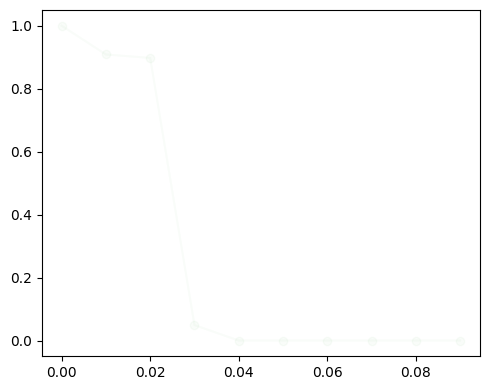

In [127]:
plt.figure(figsize=(5, 4))
fittest = pop[np.argsort(-fitnesses)[0]]
for attribute in range(Xnum.shape[1]):
    print(fittest[attribute][-1])
    plt.plot(np.linspace(0, 1, 101)[:10], fittest[attribute][:10], "-o", alpha=fittest[attribute][-1])
plt.tight_layout()
plt.show()

In [81]:
dataset["categorical_attributes"]

array(['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal'],
      dtype=object)

In [132]:
from sklearn.metrics import normalized_mutual_info_score
i = 1
print(normalized_mutual_info_score(clusters, Xcat[:, i]))
attribute = Xnum.shape[1] + i
print(fittest[attribute][-1], dataset["categorical_attributes"][i])
n_categories = int((1 + np.sqrt(1 + 8*(len(fittest[attribute])-1)))/2) # n**2 - n - 2*(len(solution[attribute])-1) = 0 => n = (-b + sqrt(Delta)/2a)
m = np.identity(n_categories)
iu = np.triu_indices(n_categories, 1)
m[iu] = fittest[attribute][:-1]
print(m)

0.005096548390390666
0.0 cp
[[1.         0.50252692 0.09285835 0.45967556]
 [0.         1.         0.58244784 0.22150877]
 [0.         0.         1.         0.97580909]
 [0.         0.         0.         1.        ]]


In [117]:
from sklearn.manifold import MDS, TSNE

sim_matrix = get_sim_matrix(fittest, Xnum, Xcat)
# Xemb = MDS(n_components=2, metric="precomputed", init="random").fit_transform(1 - sim_matrix)
Xemb = MDS(n_components=2, dissimilarity="precomputed").fit_transform(1 - sim_matrix)

/homedir/adiop/workspace/simrec-for-mdc/venv/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


In [123]:
clusters = AgglomerativeClustering(n_clusters=n_clusters).fit_predict(1 - sim_matrix)
get_unsupervised_score(1 - sim_matrix, clusters, eval_metric=eval_metric, metric="precomputed")

/homedir/adiop/workspace/simrec-for-mdc/venv/lib/python3.8/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


0.5030531843262773

2 (array([0, 1]), array([272,  24]))


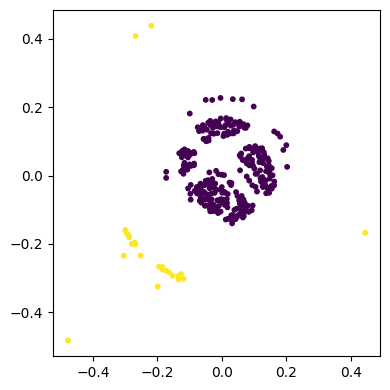

In [126]:
plt.figure(figsize=(4, 4))
print(n_clusters, np.unique(clusters, return_counts=True))
plt.scatter(Xemb[:, 0], Xemb[:, 1], c=clusters, s=10)
plt.tight_layout()
plt.show()

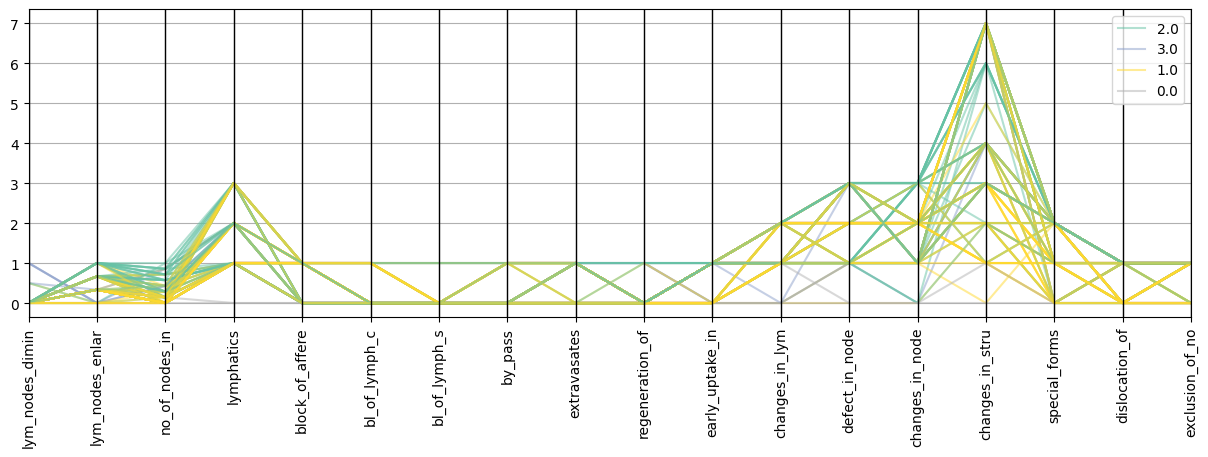

In [68]:
from pandas.plotting import parallel_coordinates

df = pd.DataFrame(
    data=np.c_[Xnum, Xcat, np.reshape(dataset["y"], (-1, 1))],
    columns=list(dataset["numeric_attributes"]) + list(dataset["categorical_attributes"]) + ["class"]
)
plt.figure(figsize=(15, 4))
parallel_coordinates(df, "class", colormap=plt.get_cmap("Set2"), alpha=0.5)
plt.xticks(rotation="vertical")
plt.show()